# Modules & Functions

In [1]:
import sys
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion, RectangleSkyRegion
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, MapDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, FoVBackgroundModel, Models
from gammapy.estimators import FluxPoints,FluxPointsEstimator, ExcessMapEstimator
%matplotlib inline
import sys, os
import numpy as np
import itertools
import re
import datetime
import gammapy
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.stats import CashCountsStatistic, cash, cash_sum_cython
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore, Observations
from gammapy.datasets import Datasets, FluxPointsDataset, MapDatasetOnOff
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, DiskSpatialModel, TemplateSpatialModel, PowerLawNormSpectralModel
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion, EllipseSkyRegion
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
    EnergyDependentMorphologyEstimator)
# from common_utils import get_excluded_regions
#from gammapy.utils.regions import make_region
from gammapy.modeling.models import FoVBackgroundModel, GaussianSpatialModel, ShellSpatialModel, DiskSpatialModel, PiecewiseNormSpectralModel
from gammapy.makers import FoVBackgroundMaker
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator, FluxMaps
from gammapy.maps import WcsNDMap
from gammapy.visualization import plot_npred_signal, plot_distribution
import ipywidgets
from gammapy.modeling.models import Models
from astropy.coordinates import Angle
from collections import OrderedDict
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import datetime
from scipy.stats import chi2, norm
from astropy.table import Table
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
DB_general = pd.read_csv('/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial/db_data.csv', header=0)
import sys  
sys.path.insert(1, '/home/hpc/caph/mppi103h/Documents/On-OFF-matching-woody')
from scipy.optimize import curve_fit
import common_utils
from common_utils import get_excluded_regions
from matplotlib.lines import Line2D
from PIL import Image
sys.path.insert(1, '/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial')
import my_utility_functions as muf
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.catalog import SourceCatalog4FGL

In [2]:
import sys  
sys.path.insert(2, '/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial/Monogem_on_off_bkg/')

In [ ]:
from importlib import reload
#reload(util)
reload(muf)

In [ ]:
import run_matching_algorithm as rma
reload(rma)

In [ ]:
PlotDir = '/home/wecapstor1/caph/caph101h/projects/test_projects/2FGL_J1044.5-5737/Plots/Run_matching/'

In [ ]:
muon_phases2 = [20000, 40093, 57532, 60838, 63567, 68545, 80000, 85000, 95003, 100800, 110340, 127700, 128600, 132350, 154814, 190000]

DB_general = pd.read_csv(r'/home/wecapstor1/caph/shared/hess/fits/database_image/data_1223.csv', header=0)
correction_factor = pd.read_csv(r'/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial/zenith_correction_factors.csv', sep='\t')

offset_max = 2*u.deg

In [ ]:
def plot_position(_ax_, ra, dec, name, _marker_):
    
    position = SkyCoord(ra, dec, frame='icrs', unit='deg')
    _ax_.text(position.ra.deg+.75, position.dec.deg+.05, name,color=_marker_['color'],transform=_ax_.get_transform('world'))
    _ax_.plot(position.ra.deg, position.dec.deg, **_marker_, transform=_ax_.get_transform('world'))

In [ ]:
def chi2_(A, B):
    chi = np.sum([((a - b) ** 2) / (b) for (a, b) in zip(A, B)])
    return chi

def chi_squared_calculator(flux_points, sky_model):
    """
    Calculate chi-squared between observed flux points and model predictions.

    Parameters:
    - flux_points: FluxPoints object containing the observed flux points data.
    - model: Spectral model object to compare with flux points.
    - delta_e: Small energy range around each flux point for flux prediction (default: 0.1 TeV).
    
    Returns:
    - chi2_values: List of chi-squared values for each flux point.
    """
    # Extract the observed flux and energy data
    mask = np.isfinite(flux_points.e2dnde.data[:, 0, 0])  # Filter out non-finite values
    observed_flux = flux_points.e2dnde.data[mask][:, 0, 0]  # Observed flux values
    energy_axis = flux_points.energy_axis

    predicted_flux = sky_model.spectral_model.reference_fluxes(energy_axis)["ref_e2dnde"] * u.Unit("cm2 s / TeV")

    result = chi2_(observed_flux, predicted_flux)

    exponents = np.floor(np.log10(observed_flux, predicted_flux))
    unique_exponents, counts = np.unique(exponents, return_counts=True)

    # Find the most common exponent
    most_common_exponent = unique_exponents[np.argmax(counts)]

    # Automate the multiplier based on the exponent
    result *= 10**(-most_common_exponent)
   
    return result

def source_regions_plot(_ax_, _catalog_, _marker_):
    """
    Plot all sources within 4 deg of ra, dec = (160.81, -58.85)
    """
    for index in range(len(_catalog_.table)):
        ra = _catalog_.table[index]["RAJ2000"]
        dec = _catalog_.table[index]["DEJ2000"]
        name = _catalog_.table[index]["Source_Name"]

        position = SkyCoord(ra, dec, frame='icrs', unit='deg')
        _ax_.text(position.ra.deg+.75, position.dec.deg+.1, name, weight='bold',color=_marker_['color'],transform=_ax_.get_transform('world'))
        _ax_.plot(position.ra.deg, position.dec.deg, **_marker_, transform=_ax_.get_transform('world'))

def plot_spectrum(model, flux_points, energy_power, label, color):
    spec = model.spectral_model
    energy_range = [.1, 100] * u.TeV
    
    if energy_power == 0:
        # Plot the model spectrum
        spec.plot(energy_bounds=energy_range, energy_power=energy_power, label=label, color=color)
        spec.plot_error(energy_bounds=energy_range, energy_power=energy_power, color=color)
        
        # Plot the flux points
        flux_points.plot(energy_power=energy_power, color=color)
        
        # Set the ylabel dynamically based on energy_power
        plt.ylabel(r'dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
        plt.grid()
        plt.xlim(1e-1,1e2)

    else:   
        # Plot the model spectrum
        spec.plot(energy_bounds=energy_range, energy_power=energy_power, label=label, color=color)
        spec.plot_error(energy_bounds=energy_range, energy_power=energy_power, color=color)
        
        # Plot the flux points
        flux_points.plot(energy_power=energy_power, color=color)
        
        # Set the ylabel dynamically based on energy_power
        plt.ylabel(r'E$^{%d}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]' % energy_power)
        plt.xlim(1e-1,1e2)

def find_energy_with_sensitivity(f_cubic, target_bias, initial_guess, delta_bias=0.01):  
    # Calculate energy for the target bias
    energy_found = fsolve(lambda x: f_cubic(x) - target_bias, initial_guess)[0]
    
    # Calculate energy for a slightly perturbed bias (plus and minus delta_bias)
    energy_high = fsolve(lambda x: f_cubic(x) - (target_bias + delta_bias), initial_guess)[0]
    energy_low = fsolve(lambda x: f_cubic(x) - (target_bias - delta_bias), initial_guess)[0]
    
    # The energy error is the half-range of energy found by perturbing the bias
    energy_error = abs(energy_high - energy_low) / 2
    
    return energy_found, energy_error

def energy_threshold_from_bias(_dataset_, _bias_percent_):
    # Obtain energy and bias data
    energy = np.array(_dataset_.edisp.get_edisp_kernel().axes["energy_true"].center)
    energy_min = _dataset_.energy_range_total[0].value
    bias = np.array(_dataset_.edisp.get_edisp_kernel().get_bias(energy))

    mask = (energy >= energy_min)
    x = energy[mask]
    y = bias[mask]

    # Create a cubic spline interpolation function with extrapolation
    f_cubic = interp1d(x, y, kind='cubic', fill_value='extrapolate')

    bias_energy_below_5_percent_low, error_low = find_energy_with_sensitivity(f_cubic, _bias_percent_*1e-2, initial_guess=.25)

    return bias_energy_below_5_percent_low, error_low 

In [ ]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_energy_threshold(dataset):
    number = 0
    for k in range(0,dataset.counts.data.shape[0]): 
        for l in range(0,dataset.counts.data.shape[1]):
            for n in range(0,dataset.counts.data.shape[2]):
                if dataset.mask_safe.data[k][l][n] == True:
                    number = k 
                    break
        if number != 0:
            break
    return number

def get_exclusion_mask(off_run, geom_off, radius, radius_source_mask):
    """ Define the exclusion mask that will be used for the background fit """ 
    
    hap_exclusion_regions = get_excluded_regions(geom_off.center_coord[0].value, geom_off.center_coord[1].value, radius)
    excl_regions = []
    for source in hap_exclusion_regions:
        center = SkyCoord(source.ra, source.dec, unit='deg', frame='icrs')
        region = CircleSkyRegion(center=center, radius=source.radius*u.deg)
        excl_regions.append(region)

    tel_pointing = off_run.pointing.fixed_icrs
    source_pos = DB_general[DB_general['Run']==off_run.obs_id]
    ra = tel_pointing.ra.value #- source_pos['Offset_x'].iloc[0]
    dec = tel_pointing.dec.value #- source_pos['Offset_y'].iloc[0]
    excl_regions.append(CircleSkyRegion(center=SkyCoord(ra*u.deg, dec*u.deg), radius=radius_source_mask*u.deg))
    
    region_mask = geom_off.region_mask(regions=excl_regions, inside=False)
    energy_mask = geom_off.energy_mask(1 * u.TeV, 100 * u.TeV)
    final_mask = region_mask & energy_mask 
    
    maker_fov_off = FoVBackgroundMaker(method="fit", exclusion_mask=final_mask)
    ex = maker_fov_off.exclusion_mask.cutout(off_run.pointing.fixed_icrs, width=2 * offset_max)
    return maker_fov_off, ex

def adjust_energy_threshold(dataset, number):
    """ Apply a predifined save energy to the counts and background of a dataset """
    
    bkg_array = np.zeros_like(dataset.data)
    for a in range(number, bkg_array.shape[0]):
        for b in range(0,dataset.data.shape[1]):
            for c in range(0,dataset.data.shape[2]):
                bkg_array[a][b][c] = dataset.data[a][b][c]
    
    masked_data = WcsNDMap(geom=dataset.geom, data=np.array(bkg_array))
    return masked_data

def livetime_corr(obs, off_run, dataset):
    """ Correct for the differences in deadtime corrected observation time """
    
    livetime_dev = off_run.observation_live_time_duration.value - obs.observation_live_time_duration.value
    counts_per_sec = dataset.background.data/off_run.observation_live_time_duration.value
    factors = counts_per_sec*livetime_dev
    bkg = [x + y for x, y in zip(dataset.background.data, factors)]

    bkg = WcsNDMap(geom=dataset.counts.geom, data=np.array(bkg))
    dataset.background = bkg
    return dataset

    
def zenith_corr(obs, off_run, dataset):
    """ Correct for the differences in zenith angle """
    
    for phase in range(0,len(muon_phases2)-1):
        if obs.obs_id > muon_phases2[phase] and obs.obs_id < muon_phases2[phase+1]:
            factor = correction_factor.x_2.iloc[phase]

    bkg = dataset.background.data
    zenith_off = np.deg2rad(ds.obs_table[ds.obs_table['OBS_ID']==off_run.obs_id]["ZEN_PNT"])
    zenith_on = np.deg2rad(ds.obs_table[ds.obs_table['OBS_ID']==obs.obs_id]["ZEN_PNT"])
    bkg = np.array(bkg) * np.cos(zenith_on - zenith_off)**factor
    
    bkg = WcsNDMap(geom=dataset.counts.geom, data=np.array(bkg))
    dataset.background = bkg
    return dataset

def systematics(obs, off_run, dataset, sys):
    """ Get the upper or lower limit of the background rate from the systematic error on the background template and run matching """
    run_dev = self.deviation[self.obs_list.index(obs)]
    bkg = dataset.background.data
    binsz = (self.systematic_shift['run dev'].iloc[1] - self.systematic_shift['run dev'].iloc[0])/2
    for i in range(0,len(self.systematic_shift)):
        if run_dev > self.systematic_shift['run dev'].iloc[i]-binsz and run_dev < self.systematic_shift['run dev'].iloc[i]+binsz:
            index = i
            sys_factor = self.systematic_shift['sys dev error'].iloc[i]
            if sys_factor == 0:
                closest_filled = index - min((index - self.systematic_shift[self.systematic_shift['sys dev'] != 0].index), key=abs)
                sys_factor = self.systematic_shift['sys dev error'].iloc[closest_filled]
        
        elif run_dev < self.systematic_shift['run dev'].iloc[0]:
            sys_factor = self.systematic_shift['sys dev error'].iloc[0]

        elif run_dev > self.systematic_shift['run dev'].iloc[-1]:
            sys_factor = self.systematic_shift['sys dev error'].iloc[-1]
    
    if sys == 'low':
        bkg = [x - x*sys_factor for x in bkg] 
    elif sys == 'high':
        bkg = [x + x*sys_factor for x in bkg]   
    
    bkg = WcsNDMap(geom=dataset.counts.geom, data=np.array(bkg))
    dataset.background = bkg
    return dataset

In [ ]:
# Function to find better matches
def refine_matches(df, first_match_df, excluded_off_run_ids, used_off_runs, excess_threshold):
    on_run_ids_needing_better_matches = set()

    # Identify On_run_ids that need better matches
    for _, row in first_match_df.iterrows():
        if row['Excess'] < excess_threshold:
            on_run_ids_needing_better_matches.add(row['On_run_id'])

    # Remove the pairs with Excess < -100 from first_match_df
    first_match_df = first_match_df[first_match_df['Excess'] >= excess_threshold]

    # Iterate through each On_run_id that needs a better match
    for on_run_id in on_run_ids_needing_better_matches:
        # Filter the original DataFrame for the current On_run_id, excluding used Off_run_ids
        on_df = df[(df['On_run_id'] == on_run_id) & (~df['Off_run_id'].isin(used_off_runs))]

        # If there are no remaining Off_run_ids for this On_run_id, skip it
        if on_df.empty:
            continue

        # Sort the rows by score to find the best remaining matches
        sorted_on_df = on_df.sort_values(by='Score')

        # Try to find a better match
        for _, best_row in sorted_on_df.iterrows():
            off_run_id = best_row['Off_run_id']

            # Skip if the Off_run_id is in the excluded list
            if off_run_id in excluded_off_run_ids:
                continue

            # Skip if the Off_run_id has already been used
            if off_run_id in used_off_runs:
                continue

            # Add the new best match to first_match_df
            first_match_df = pd.concat([first_match_df, pd.DataFrame([best_row])], ignore_index=True)

            # Mark this Off_run_id as used
            used_off_runs.add(off_run_id)

            # Break after finding a valid match
            break

    return first_match_df, used_off_runs

# Define the scoring function
def calculate_score(row):
    # Weighted combination of Norm, Tilt, and Deviation
    # score = abs(row['Norm'] - 1) + abs(row['Tilt']) #+ abs(row['Deviation']) + abs(row['Mu_off']) + abs(row['Std_off'] - 1)
    score = abs(row['Deviation'])
    return score

def plot_spectrum(model, flux_points, energy_power, label, color):
    spec = model.spectral_model
    energy_range = [.1, 100] * u.TeV
    
    if energy_power == 0:
        # Plot the model spectrum
        spec.plot(energy_bounds=energy_range, energy_power=energy_power, label=label, color=color)
        spec.plot_error(energy_bounds=energy_range, energy_power=energy_power, color=color)
        
        # Plot the flux points
        flux_points.plot(energy_power=energy_power, color=color)
        
        # Set the ylabel dynamically based on energy_power
        plt.ylabel(r'dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
        plt.grid()
        plt.xlim(1e-1,1e2)

    else:   
        # Plot the model spectrum
        spec.plot(energy_bounds=energy_range, energy_power=energy_power, label=label, color=color)
        spec.plot_error(energy_bounds=energy_range, energy_power=energy_power, color=color)
        
        # Plot the flux points
        flux_points.plot(energy_power=energy_power, color=color)
        
        # Set the ylabel dynamically based on energy_power
        plt.ylabel(r'E$^{%d}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]' % energy_power)
        plt.xlim(1e-1,1e2)

def chi2_(A, B):
    chi = np.sum([((a - b) ** 2) / (b) for (a, b) in zip(A, B)])
    return chi

def chi_squared_calculator(flux_point_data, flux_names):
    results_dict = {}
    for flux_name, flux_point_data in zip(flux_names, flux_points_container):
        mask = np.isfinite(flux_point_data.e2dnde.data[:, 0, 0]) & (flux_point_data.e2dnde.data[:, 0, 0] > 1e-14)
        data = flux_point_data.e2dnde.data[mask][:,0][:,0]
        ref_energy = np.array(flux_point_data.e2dnde_ref[mask])[:,0][:,0]
        
        # Calculate the chi-squared result
        result = chi2_(data, ref_energy)
        
        # Extract the exponent part of the result
        exponent = np.floor(np.log10(abs(result)))
        
        # Automate the multiplier based on the exponent
        result *= 10**(-exponent)
        
        # Store the result in the dictionary
        results_dict[flux_name] = result

    return results_dict

In [ ]:
def NSB_account(dataset_,nsb_mean_, nsb_pixel_, hardware_pixel_mean_, number_):
    # Calculate the total number of pixels from all telescopes
    hardware_pixel_mean_ / 4 # Mean broken Hardware pxiels
    nsb_pixel_red = nsb_pixel_ / 4 # Mean broken NSB pxiels
    nsb_val = nsb_mean_ / 4 # Mean Pedestial NSB value

    num_pixel = ((960-hardware_pixel_mean_) * 4)
    
    # Calculate the fraction of affected pixels due to high NSB counts
    fraction_aff_pixel = nsb_pixel_red / num_pixel 

    data_ = dataset_.data 
    
    counts_per_energy_bin = data_.sum(axis=(1, 2))

    # Calculate total background counts across all energy bins
    total_counts_all_energies = data_.sum()

    # Calculate the fraction of counts in each energy bin compared to total background counts (all energies)
    fractions = counts_per_energy_bin / total_counts_all_energies
    fractions_safe = np.zeros_like(fractions)
    fractions_safe[number_:] = fractions[number_:]
    

    # Set limits for NSB comparison
    expected_nsb_max = 90

    fraction_expected_nsb = np.abs(nsb_val - expected_nsb_max)/expected_nsb_max
    
    # Apply fraction adjustment based on NSB value
    if nsb_val <= expected_nsb_max:
        frac_adjustment = 0
        affected_nsb_run_ = 'Not affected'
        num_ = 0
    else:
        # Adjust background counts with both the affected pixel fraction and energy-dependent fractions
        frac_adjustment = ((fraction_aff_pixel + fraction_expected_nsb) * fractions_safe[:, np.newaxis, np.newaxis]) 
        affected_nsb_run_ = 'Affected'
        num_ = 1

    # Set limits for NSB comparison
    expected_nsb_max = 100
    nsb_max_1 = 150
    nsb_max_2 = 200

    fraction_expected_nsb = np.abs(nsb_val - expected_nsb_max)/expected_nsb_max
    
    # Apply fraction adjustment based on NSB value
    if nsb_val <= expected_nsb_max:
        frac_adjustment = 0
        affected_nsb_run_ = 'Not affected'
        num_ = 0
    elif expected_nsb_max < nsb_val <= nsb_max_1:
        frac_adjustment = ((fraction_aff_pixel + fraction_expected_nsb) * fractions_safe[:, np.newaxis, np.newaxis]) 
        affected_nsb_run_ = 'Affected, between 100-150'
        num_ = 1
    elif nsb_max_1 < nsb_val <= nsb_max_2:
        frac_adjustment = ((fraction_aff_pixel + fraction_expected_nsb*2) * fractions_safe[:, np.newaxis, np.newaxis])
        affected_nsb_run_ = 'Affected, between 150-200'
        num_ = 1
    else:
        frac_adjustment = ((fraction_aff_pixel + fraction_expected_nsb*3) * fractions_safe[:, np.newaxis, np.newaxis])
        affected_nsb_run_ = 'Affected, above 200'
        num_ = 1

    
    # Adjust the model background counts
    adjusted_data_ = data_ * (1 + frac_adjustment)
    
    # Create a new WcsNDMap with the adjusted background counts
    adjusted_counts_ = WcsNDMap(geom=dataset_.geom, data=adjusted_data_)    

    return adjusted_counts_, num_, affected_nsb_run_

In [ ]:
def gaussian(x, amplitude, mean, stddev):
    """
    Gaussian function.
    
    Parameters:
    - x: Independent variable
    - amplitude: Peak value of the Gaussian
    - mean: Mean (center) of the Gaussian
    - stddev: Standard deviation (width) of the Gaussian
    
    Returns:
    - Gaussian function values
    """
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev) ** 2)

def fit_gaussian(x_data, y_data):
    """
    Fits a Gaussian normal distribution to the given data.
    
    Parameters:
    - x_data: Array of x values
    - y_data: Array of y values
    
    Returns:
    - popt: Optimal values for the Gaussian parameters (amplitude, mean, stddev)
    - pcov: Covariance of the parameters
    """
    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [max(y_data), np.mean(x_data), np.std(x_data)]
    
    # Fit the Gaussian to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    error = np.diag(np.sqrt(pcov))
    return popt, error

# Data analysis (do not run this)

In [23]:
directory = '/home/vault/caph/caph101h/datasets/2FGL_J1044_point_5_5737/individual_matching/datasets/'

df = muf.load_data_to_dataframe([directory])
df['On run Id'] = df['On run Id'].astype(int)
df['Off run Id'] = df['Off run Id'].astype(int)
df['Deviation'] = df['Deviation'].astype(float)

grouped = df.groupby('On run Id', group_keys=False).apply(lambda x: x.nsmallest(len(df['Off run Id']), 'Deviation'))

print(len(grouped['On run Id'].unique()), 'On runs')

67 On runs


In [24]:
on_runs = np.array(grouped['On run Id'])
off_runs = np.array(grouped['Off run Id'])
deviation = np.array(grouped['Deviation'])

In [25]:
basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/std_ImPACT_fullEnclosure_updated/'

# Load DataStores
ds = DataStore.from_dir(basedir,
                            'hdu-index.fits.gz',
                            'obs-index.fits.gz'
                           )

obs_list_on = ds.get_observations(on_runs, skip_missing=True)
obs_list_off = ds.get_observations(off_runs, skip_missing=True)

print(f'{len(obs_list_on)} runs in the On observation list')
print(f'{len(obs_list_off)} runs in the Off observation list')
print(f'{len(deviation)} fractional run deviations. Mean value {round(np.mean(deviation),3)}')

2188 runs in the On observation list
2188 runs in the Off observation list
2188 fractional run deviations. Mean value 1.332


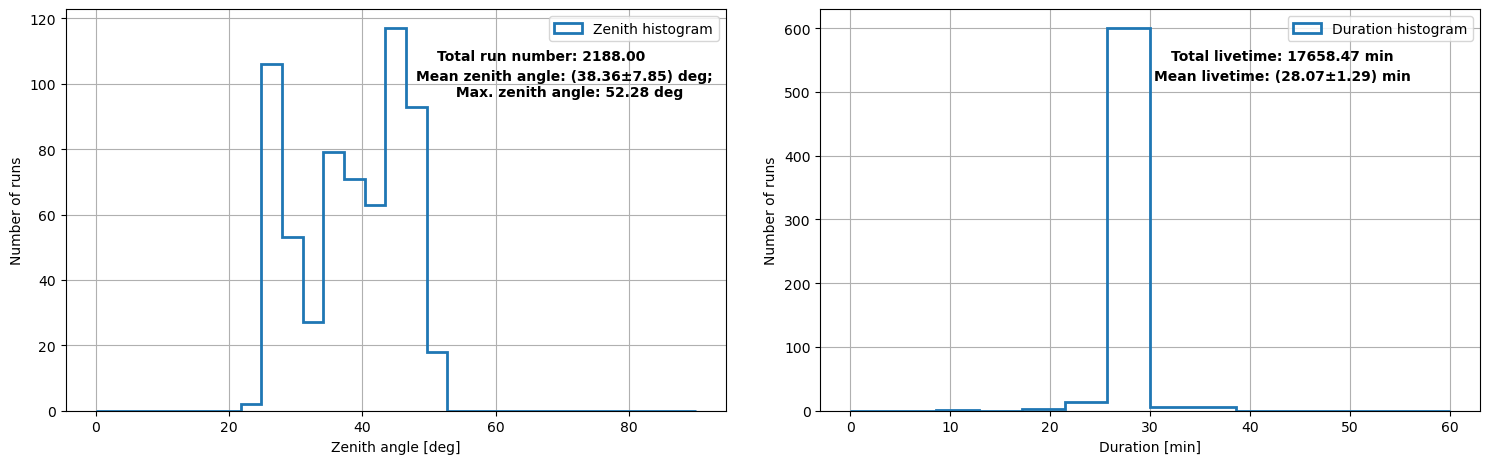

In [26]:
indices = np.where(np.isin(ds.obs_table['OBS_ID'], off_runs))
zenith_angles = ds.obs_table['ZEN_PNT'][indices]
livetime = ds.obs_table['LIVETIME'][indices] / 60

mean_zenith_angle = np.mean(zenith_angles)
max_zenith_angle = np.max(zenith_angles)
std_zenith_angle =  np.std(zenith_angles)
total_livetime = np.sum(livetime)
run_num = len(obs_list_off)
mean_livetime = np.mean(livetime)
std_livetime = np.std(livetime)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(zenith_angles, bins=np.linspace(0, 90, 30), histtype='step', lw=2, label = 'Zenith histogram')
ax1.set_xlabel('Zenith angle [deg]')
ax1.set_ylabel('Number of runs')
ax1.text(.72, 0.9, f'Total run number: {run_num:.2f}', ha='center', va='top', transform=ax1.transAxes,
        fontsize=10, color='black', fontweight='bold')
ax1.text(.76, 0.85, f'Mean zenith angle: ({mean_zenith_angle:.2f}±{std_zenith_angle:.2f}) deg; \n Max. zenith angle: {max_zenith_angle:.2f} deg', ha='center', va='top', transform=ax1.transAxes,
        fontsize=10, color='black', fontweight='bold')
ax1.grid()
ax1.legend()

ax2.hist(livetime, bins=np.linspace(0, 60, 15), histtype='step', lw=2, label = 'Duration histogram')
ax2.text(.7, 0.9, f'Total livetime: {total_livetime:.2f} min', ha='center', va='top', transform=ax2.transAxes,
        fontsize=10, color='black', fontweight='bold')
ax2.text(.7, 0.85, f'Mean livetime: ({mean_livetime:.2f}±{std_livetime:.2f}) min', ha='center', va='top', transform=ax2.transAxes,
       fontsize=10, color='black', fontweight='bold')
ax2.set_xlabel('Duration [min]')
ax2.set_ylabel('Number of runs')
ax2.grid()
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
# name = 'run_matching_hess_1u_off_runs_zenith_and_livetime_histogram'
# muf.save_figures(PlotDir,name)
plt.show()

In [27]:
e_reco = np.logspace(-1, 2, 60) * u.TeV 
e_true = np.logspace(-1, 2, 120) * u.TeV 

energy_axis = MapAxis.from_edges(e_reco, unit='TeV', name='energy', interp='log')
energy_axis_true = MapAxis.from_edges(e_true, unit='TeV', name="energy_true", interp='log')

ra,dec = (160.5, -59)
bins = 0.01 # Degrees
FOV_width = (8, 8)  # Degrees

geom = WcsGeom.create(
    skydir=(ra, dec),
    binsz=bins,
    width=FOV_width,
    frame="icrs",
    proj="CAR",
    axes=[energy_axis])

In [28]:
maker = MapDatasetMaker()

maker_safe_mask = SafeMaskMaker(methods=["offset-max", 'aeff-default', 'aeff-max', 'edisp-bias', 'bkg-peak'],offset_max=offset_max, bias_percent=5)

In [19]:
from scipy.stats import chi2, norm

stacked_name = f'Monogem_stacked_Dataset'
stacked = MapDataset.create(geom=geom, name=stacked_name, energy_axis_true=energy_axis_true)

# Initialize the results table
Table_bkg_fit_data = {
    'On_run_id': [],
    'Off_run_id': [],
    'Deviation': [],
    'Tilt': [],
    'Norm': [],
    'Excess': [],
    'Mu_off': [],
    'Std_off': []
}

for m in range(len(obs_list_off)):
    print(f'{m} of {len(obs_list_off)} ')
    obs = obs_list_on[m]
    off_run = obs_list_off[m]
    dev = deviation[m]
    
    # ON run dataset geometry 
    cutout = stacked.cutout(obs.pointing.fixed_icrs, width=2*offset_max, name=f"obs-{obs.obs_id}")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs)   
    
    number_on = find_energy_threshold(dataset)
    
    # OFF run dataset geometry
    geom_off = WcsGeom.create(
        skydir=off_run.pointing.fixed_icrs, 
        binsz=bins, 
        width=FOV_width, 
        frame="icrs", 
        proj="CAR", 
        axes=[energy_axis]
    )
    
    stacked_off = MapDataset.create(
        geom=geom_off, 
        name=f"obs-{off_run.obs_id}", 
        energy_axis_true=energy_axis_true
    )

    cutout_off = stacked_off.cutout(off_run.pointing.fixed_icrs, width=2*offset_max, name=f"obs-{off_run.obs_id}")
    
    # Define exclusion region and safe mask for the background fit
    maker_fov_off, ex = get_exclusion_mask(off_run, geom_off, 10, radius_source_mask=.3)
    
    # Fit the background to the OFF run
    dataset_off = maker.run(cutout_off, off_run)
    dataset_off = maker_safe_mask.run(dataset_off, off_run)
    
    number_off = find_energy_threshold(dataset_off)
    
    # Find the highest energy threshold between ON and OFF run
    number = max(number_on, number_off)
    
    # Apply the energy threshold to both ON and OFF runs
    dataset.background = adjust_energy_threshold(dataset.background, number)
    dataset.counts = adjust_energy_threshold(dataset.counts, number)
    dataset_off.background = adjust_energy_threshold(dataset_off.background, number)
    dataset_off.counts = adjust_energy_threshold(dataset_off.counts, number)
    
    # The background fit
    bkg_model_off = FoVBackgroundModel(dataset_name=dataset_off.name)
    dataset_off.models = bkg_model_off
    dataset_off.background_model.spectral_model.tilt.frozen = False
    dataset_off = maker_fov_off.run(dataset_off)
    
    bkg_model_on = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = bkg_model_on
    
    dataset.background_model.spectral_model.norm.value = dataset_off.background_model.spectral_model.norm.value
    dataset.background_model.spectral_model.tilt.value = dataset_off.background_model.spectral_model.tilt.value
    
    dataset.background_model.spectral_model.norm.frozen = True
    dataset.background_model.spectral_model.tilt.frozen = True
    
    # Apply the corrections
    dataset = livetime_corr(obs, off_run, dataset)
    dataset = zenith_corr(obs, off_run, dataset)

     #Significance of the model:
    estimator_001 = ExcessMapEstimator(correlation_radius="0.1 deg")
    lima_maps_001 = estimator_001.run(dataset_off)
    
    significance_map = lima_maps_001["sqrt_ts"] 
    significance_off = significance_map.data[np.isfinite(significance_map.data)]
    mu, std = norm.fit(significance_off)
    mu = np.round(mu,3)
    std = np.round(std,3)
    
    # Store results
    Table_bkg_fit_data['On_run_id'].append(obs.obs_id)   
    Table_bkg_fit_data['Off_run_id'].append(off_run.obs_id)   
    Table_bkg_fit_data['Deviation'].append(dev)   
    Table_bkg_fit_data['Tilt'].append(dataset.background_model.spectral_model.tilt.value)    
    Table_bkg_fit_data['Norm'].append(dataset.background_model.spectral_model.norm.value)    
    Table_bkg_fit_data['Excess'].append(dataset.info_dict()['excess'])
    Table_bkg_fit_data['Mu_off'].append(mu)
    Table_bkg_fit_data['Std_off'].append(std)

    
    # Optionally, clear other large variables to free memory
    import gc
    gc.collect()

Missing 'HDUCLAS2' keyword assuming 'BKG'


0 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'


1 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


3 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


4 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


5 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


6 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


7 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


8 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


9 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


10 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


11 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


12 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


13 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


14 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


15 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


16 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


17 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


18 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


19 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


20 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


21 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


22 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


23 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


24 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


25 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


26 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


27 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


28 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


29 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


30 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


31 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


32 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


33 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


34 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


35 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


36 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


37 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


38 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


39 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


40 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


41 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


42 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


43 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


44 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


45 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


46 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


47 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


48 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


49 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


50 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


51 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


52 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


53 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


54 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


55 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


56 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


57 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


58 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


59 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


60 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


61 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


62 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


63 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


64 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


65 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


66 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


67 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


68 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


69 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


70 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


71 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


72 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


73 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


74 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


75 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


76 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


77 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


78 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


79 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


80 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


81 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


82 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


83 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


84 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


85 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


86 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


87 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


88 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


89 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


90 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


91 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


92 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


93 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


94 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


95 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


96 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


97 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


98 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


99 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


100 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


101 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


102 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


103 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


104 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


105 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


106 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


107 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


108 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


109 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


110 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


111 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


112 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


113 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


114 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


115 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


116 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


117 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


118 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


119 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


120 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


121 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


122 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


123 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


124 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


125 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


126 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


127 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


128 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


129 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


130 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


131 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


132 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


133 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


134 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


135 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


136 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


137 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


138 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


139 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


140 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


141 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


142 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


143 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


144 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


145 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


146 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


147 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


148 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


149 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


150 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


151 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


152 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


153 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


154 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


155 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


156 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


157 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


158 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


159 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


160 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


161 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


162 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


163 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


164 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


165 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


166 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


167 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


168 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


169 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


170 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


171 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


172 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


173 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


174 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


175 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


176 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


177 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


178 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


179 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


180 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


181 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


182 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


183 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


184 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


185 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


186 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


187 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


188 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


189 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


190 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


191 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


192 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


193 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


194 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


195 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


196 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


197 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


198 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


199 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


200 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


201 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


202 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


203 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


204 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


205 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


206 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


207 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


208 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


209 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


210 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


211 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


212 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


213 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


214 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


215 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


216 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


217 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


218 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


219 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


220 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


221 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


222 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


223 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


224 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


225 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


226 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


227 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


228 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


229 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


230 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


231 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


232 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


233 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


234 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


235 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


236 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


237 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


238 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


239 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


240 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


241 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


242 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


243 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


244 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


245 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


246 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


247 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


248 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


249 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


250 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


251 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


252 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


253 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


254 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


255 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


256 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


257 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


258 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


259 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


260 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


261 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


262 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


263 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


264 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


265 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


266 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


267 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


268 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


269 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


270 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


271 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


272 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


273 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


274 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


275 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


276 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


277 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


278 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


279 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


280 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


281 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


282 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


283 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


284 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


285 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


286 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


287 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


288 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


289 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


290 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


291 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


292 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


293 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


294 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


295 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


296 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


297 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


298 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


299 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


300 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


301 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


302 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


303 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


304 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


305 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


306 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


307 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


308 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


309 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


310 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


311 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


312 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


313 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


314 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


315 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


316 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


317 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


318 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


319 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


320 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


321 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


322 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


323 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


324 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


325 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


326 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


327 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


328 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


329 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


330 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


331 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


332 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


333 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


334 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


335 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


336 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


337 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


338 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


339 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


340 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


341 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


342 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


343 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


344 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


345 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


346 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


347 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


348 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


349 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


350 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


351 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


352 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


353 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


354 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


355 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


356 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


357 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


358 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


359 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


360 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


361 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


362 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


363 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


364 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


365 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


366 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


367 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


368 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


369 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


370 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


371 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


372 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


373 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


374 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


375 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


376 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


377 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


378 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


379 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


380 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


381 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


382 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


383 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


384 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


385 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


386 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


387 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


388 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


389 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


390 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


391 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


392 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


393 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


394 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


395 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


396 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


397 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


398 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


399 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


400 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


401 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


402 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


403 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


404 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


405 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


406 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


407 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


408 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


409 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


410 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


411 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


412 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


413 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


414 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


415 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


416 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


417 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


418 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


419 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


420 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


421 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


422 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


423 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


424 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


425 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


426 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


427 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


428 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


429 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


430 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


431 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


432 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


433 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


434 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


435 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


436 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


437 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


438 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


439 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


440 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


441 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


442 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


443 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


444 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


445 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


446 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


447 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


448 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


449 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


450 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


451 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


452 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


453 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


454 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


455 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


456 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


457 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


458 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


459 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


460 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


461 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


462 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


463 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


464 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


465 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


466 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


467 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


468 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


469 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


470 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


471 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


472 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


473 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


474 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


475 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


476 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


477 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


478 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


479 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


480 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


481 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


482 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


483 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


484 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


485 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


486 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


487 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


488 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


489 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


490 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


491 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


492 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


493 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


494 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


495 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


496 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


497 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


498 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


499 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


500 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


501 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


502 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


503 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


504 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


505 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


506 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


507 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


508 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


509 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


510 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


511 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


512 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


513 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


514 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


515 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


516 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


517 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


518 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


519 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


520 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


521 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


522 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


523 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


524 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


525 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


526 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


527 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


528 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


529 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


530 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


531 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


532 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


533 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


534 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


535 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


536 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


537 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


538 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


539 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


540 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


541 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


542 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


543 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


544 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


545 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


546 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


547 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


548 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


549 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


550 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


551 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


552 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


553 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


554 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


555 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


556 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


557 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


558 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


559 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


560 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


561 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


562 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


563 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


564 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


565 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


566 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


567 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


568 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


569 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


570 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


571 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


572 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


573 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


574 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


575 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


576 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


577 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


578 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


579 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


580 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


581 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


582 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


583 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


584 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


585 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


586 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


587 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


588 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


589 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


590 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


591 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


592 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


593 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


594 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


595 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


596 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


597 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


598 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


599 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


600 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


601 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


602 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


603 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


604 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


605 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


606 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


607 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


608 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


609 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


610 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


611 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


612 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


613 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


614 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


615 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


616 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


617 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


618 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


619 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


620 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


621 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


622 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


623 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


624 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


625 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


626 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


627 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


628 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


629 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


630 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


631 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


632 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


633 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


634 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


635 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


636 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


637 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


638 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


639 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


640 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


641 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


642 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


643 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


644 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


645 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


646 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


647 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


648 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


649 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


650 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


651 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


652 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


653 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


654 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


655 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


656 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


657 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


658 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


659 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


660 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


661 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


662 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


663 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


664 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


665 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


666 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


667 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


668 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


669 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


670 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


671 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


672 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


673 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


674 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


675 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


676 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


677 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


678 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


679 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


680 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


681 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


682 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


683 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


684 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


685 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


686 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


687 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


688 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


689 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


690 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


691 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


692 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


693 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


694 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


695 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


696 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


697 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


698 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


699 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


700 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


701 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


702 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


703 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


704 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


705 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


706 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


707 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


708 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


709 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


710 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


711 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


712 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


713 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


714 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


715 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


716 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


717 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


718 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


719 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


720 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


721 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


722 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


723 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


724 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


725 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


726 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


727 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


728 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


729 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


730 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


731 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


732 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


733 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


734 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


735 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


736 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


737 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


738 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


739 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


740 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


741 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


742 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


743 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


744 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


745 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


746 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


747 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


748 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


749 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


750 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


751 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


752 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


753 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


754 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


755 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


756 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


757 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


758 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


759 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


760 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


761 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


762 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


763 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


764 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


765 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


766 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


767 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


768 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


769 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


770 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


771 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


772 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


773 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


774 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


775 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


776 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


777 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


778 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


779 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


780 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


781 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


782 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


783 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


784 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


785 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


786 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


787 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


788 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


789 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


790 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


791 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


792 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


793 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


794 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


795 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


796 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


797 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


798 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


799 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


800 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


801 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


802 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


803 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


804 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


805 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


806 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


807 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


808 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


809 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


810 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


811 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


812 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


813 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


814 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


815 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


816 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


817 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


818 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


819 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


820 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


821 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


822 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


823 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


824 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


825 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


826 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


827 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


828 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


829 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


830 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


831 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


832 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


833 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


834 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


835 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


836 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


837 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


838 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


839 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


840 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


841 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


842 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


843 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


844 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


845 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


846 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


847 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


848 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


849 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


850 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


851 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


852 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


853 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


854 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


855 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


856 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


857 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


858 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


859 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


860 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


861 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


862 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


863 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


864 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


865 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


866 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


867 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


868 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


869 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


870 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


871 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


872 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


873 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


874 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


875 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


876 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


877 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


878 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


879 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


880 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


881 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


882 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


883 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


884 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


885 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


886 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


887 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


888 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


889 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


890 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


891 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


892 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


893 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


894 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


895 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


896 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


897 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


898 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


899 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


900 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


901 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


902 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


903 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


904 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


905 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


906 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


907 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


908 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


909 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


910 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


911 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


912 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


913 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


914 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


915 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


916 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


917 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


918 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


919 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


920 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


921 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


922 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


923 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


924 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


925 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


926 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


927 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


928 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


929 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


930 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


931 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


932 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


933 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


934 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


935 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


936 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


937 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


938 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


939 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


940 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


941 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


942 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


943 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


944 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


945 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


946 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


947 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


948 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


949 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


950 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


951 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


952 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


953 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


954 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


955 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


956 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


957 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


958 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


959 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


960 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


961 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


962 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


963 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


964 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


965 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


966 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


967 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


968 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


969 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


970 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


971 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


972 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


973 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


974 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


975 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


976 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


977 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


978 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


979 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


980 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


981 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


982 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


983 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


984 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


985 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


986 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


987 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


988 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


989 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


990 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


991 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


992 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


993 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


994 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


995 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


996 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


997 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


998 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


999 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1000 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1001 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1002 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1003 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1004 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1005 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1006 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1007 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1008 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1009 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1010 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1011 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1012 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1013 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1014 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1015 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1016 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1017 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1018 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1019 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1020 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1021 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1022 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1023 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1024 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1025 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1026 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1027 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1028 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1029 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1030 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1031 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1032 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1033 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1034 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1035 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1036 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1037 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1038 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1039 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1040 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1041 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1042 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1043 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1044 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1045 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1046 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1047 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1048 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1049 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1050 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1051 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1052 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1053 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1054 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1055 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1056 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1057 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1058 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1059 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1060 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1061 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1062 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1063 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1064 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1065 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1066 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1067 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1068 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1069 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1070 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1071 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1072 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1073 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1074 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1075 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1076 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1077 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1078 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1079 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1080 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1081 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1082 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1083 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1084 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1085 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1086 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1087 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1088 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1089 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1090 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1091 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1092 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1093 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1094 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1095 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1096 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1097 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1098 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1099 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1100 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1101 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1102 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1103 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1104 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1105 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1106 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1107 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1108 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1109 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1110 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1111 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1112 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1113 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1114 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1115 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1116 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1117 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1118 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1119 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1120 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1121 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1122 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1123 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1124 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1125 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1126 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1127 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1128 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1129 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1130 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1131 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1132 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1133 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1134 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1135 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1136 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1137 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1138 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1139 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1140 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1141 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1142 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1143 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1144 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1145 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1146 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1147 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1148 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1149 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1150 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1151 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1152 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1153 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1154 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1155 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1156 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1157 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1158 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1159 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1160 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1161 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1162 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1163 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1164 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1165 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1166 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1167 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1168 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1169 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1170 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1171 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1172 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1173 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1174 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1175 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1176 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1177 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1178 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1179 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1180 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1181 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1182 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1183 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1184 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1185 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1186 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1187 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1188 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1189 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1190 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1191 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1192 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1193 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1194 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1195 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1196 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1197 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1198 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1199 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1200 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1201 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1202 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1203 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1204 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1205 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1206 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1207 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1208 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1209 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1210 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1211 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1212 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1213 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1214 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1215 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1216 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1217 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1218 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1219 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1220 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1221 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1222 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1223 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1224 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1225 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1226 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1227 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1228 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1229 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1230 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1231 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1232 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1233 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1234 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1235 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1236 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1237 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1238 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1239 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1240 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1241 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1242 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1243 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1244 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1245 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1246 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1247 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1248 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1249 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1250 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1251 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1252 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1253 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1254 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1255 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1256 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1257 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1258 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1259 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1260 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1261 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1262 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1263 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1264 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1265 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1266 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1267 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1268 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1269 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1270 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1271 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1272 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1273 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1274 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1275 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1276 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1277 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1278 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1279 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1280 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1281 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1282 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1283 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1284 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1285 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1286 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1287 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1288 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1289 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1290 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1291 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1292 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1293 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1294 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1295 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1296 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1297 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1298 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1299 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1300 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1301 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1302 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1303 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1304 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1305 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1306 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1307 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1308 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1309 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1310 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1311 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1312 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1313 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1314 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1315 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1316 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1317 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1318 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1319 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1320 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1321 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1322 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1323 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1324 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1325 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1326 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1327 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1328 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1329 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1330 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1331 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1332 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1333 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1334 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1335 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1336 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1337 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1338 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1339 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1340 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1341 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1342 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1343 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1344 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1345 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1346 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1347 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1348 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1349 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1350 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1351 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1352 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1353 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1354 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1355 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1356 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1357 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1358 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1359 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1360 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1361 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1362 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1363 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1364 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1365 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1366 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1367 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1368 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1369 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1370 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1371 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1372 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1373 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1374 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1375 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1376 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1377 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1378 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1379 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1380 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1381 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1382 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1383 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1384 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1385 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1386 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1387 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1388 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1389 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1390 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1391 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1392 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1393 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1394 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1395 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1396 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1397 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1398 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1399 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1400 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1401 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1402 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1403 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1404 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1405 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1406 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1407 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1408 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1409 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1410 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1411 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1412 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1413 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1414 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1415 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1416 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1417 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1418 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1419 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1420 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1421 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1422 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1423 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1424 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1425 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1426 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1427 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1428 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1429 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1430 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1431 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1432 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1433 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1434 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1435 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1436 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1437 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1438 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1439 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1440 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1441 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1442 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1443 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1444 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1445 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1446 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1447 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1448 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1449 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1450 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1451 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1452 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1453 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1454 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1455 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1456 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1457 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1458 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1459 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1460 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1461 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1462 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1463 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1464 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1465 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1466 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1467 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1468 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1469 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1470 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1471 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1472 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1473 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1474 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1475 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1476 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1477 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1478 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1479 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1480 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1481 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1482 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1483 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1484 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1485 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1486 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1487 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1488 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1489 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1490 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1491 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1492 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1493 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1494 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1495 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1496 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1497 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1498 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1499 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1500 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1501 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1502 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1503 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1504 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1505 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1506 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1507 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1508 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1509 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1510 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1511 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1512 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1513 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1514 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1515 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1516 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1517 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1518 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1519 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1520 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1521 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1522 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1523 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1524 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1525 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1526 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1527 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1528 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1529 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1530 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1531 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1532 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1533 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1534 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1535 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1536 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1537 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1538 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1539 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1540 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1541 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1542 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1543 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1544 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1545 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1546 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1547 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1548 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1549 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1550 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1551 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1552 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1553 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1554 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1555 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1556 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1557 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1558 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1559 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1560 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1561 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1562 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1563 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1564 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1565 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1566 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1567 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1568 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1569 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1570 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1571 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1572 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1573 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1574 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1575 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1576 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1577 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1578 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1579 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1580 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1581 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1582 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1583 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1584 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1585 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1586 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1587 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1588 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1589 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1590 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1591 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1592 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1593 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1594 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1595 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1596 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1597 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1598 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1599 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1600 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1601 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1602 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1603 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1604 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1605 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1606 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1607 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1608 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1609 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1610 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1611 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1612 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1613 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1614 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1615 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1616 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1617 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1618 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1619 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1620 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1621 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1622 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1623 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1624 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1625 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1626 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1627 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1628 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1629 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1630 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1631 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1632 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1633 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1634 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1635 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1636 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1637 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1638 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1639 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1640 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1641 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1642 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1643 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1644 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1645 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1646 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1647 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1648 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1649 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1650 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1651 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1652 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1653 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1654 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1655 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1656 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1657 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1658 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1659 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1660 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1661 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1662 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1663 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1664 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1665 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1666 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1667 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1668 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1669 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1670 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1671 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1672 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1673 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1674 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1675 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1676 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1677 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1678 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1679 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1680 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1681 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1682 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1683 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1684 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1685 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1686 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1687 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1688 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1689 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1690 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1691 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1692 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1693 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1694 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1695 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1696 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1697 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1698 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1699 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1700 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1701 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1702 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1703 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1704 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1705 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1706 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1707 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1708 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1709 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1710 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1711 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1712 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1713 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1714 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1715 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1716 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1717 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1718 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1719 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1720 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1721 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1722 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1723 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1724 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1725 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1726 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1727 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1728 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1729 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1730 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1731 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1732 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1733 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1734 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1735 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1736 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1737 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1738 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1739 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1740 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1741 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1742 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1743 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1744 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1745 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1746 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1747 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1748 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1749 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1750 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1751 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1752 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1753 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1754 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1755 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1756 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1757 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1758 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1759 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1760 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1761 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1762 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1763 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1764 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1765 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1766 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1767 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1768 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1769 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1770 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1771 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1772 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1773 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1774 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1775 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1776 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1777 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1778 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1779 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1780 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1781 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1782 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1783 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1784 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1785 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1786 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1787 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1788 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1789 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1790 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1791 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1792 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1793 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1794 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1795 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1796 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1797 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1798 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1799 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1800 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1801 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1802 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1803 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1804 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1805 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1806 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1807 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1808 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1809 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1810 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1811 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1812 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1813 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1814 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1815 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1816 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1817 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1818 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1819 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1820 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1821 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1822 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1823 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1824 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1825 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1826 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1827 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1828 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1829 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1830 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1831 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1832 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1833 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1834 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1835 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1836 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1837 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1838 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1839 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1840 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1841 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1842 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1843 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1844 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1845 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1846 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1847 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1848 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1849 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1850 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1851 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1852 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1853 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1854 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1855 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1856 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1857 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1858 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1859 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1860 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1861 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1862 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1863 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1864 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1865 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1866 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1867 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1868 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1869 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1870 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1871 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1872 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1873 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1874 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1875 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1876 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1877 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1878 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1879 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1880 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1881 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1882 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1883 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1884 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1885 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1886 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1887 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1888 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1889 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1890 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1891 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1892 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1893 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1894 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1895 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1896 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1897 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1898 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1899 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1900 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1901 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1902 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1903 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1904 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1905 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1906 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1907 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1908 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1909 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1910 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1911 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1912 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1913 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1914 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1915 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1916 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1917 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1918 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1919 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1920 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1921 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1922 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1923 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1924 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1925 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1926 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1927 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1928 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1929 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1930 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1931 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1932 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1933 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1934 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1935 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1936 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1937 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1938 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1939 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1940 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1941 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1942 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1943 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1944 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1945 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1946 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1947 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1948 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1949 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1950 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1951 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1952 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1953 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1954 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1955 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1956 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1957 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1958 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1959 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1960 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1961 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1962 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1963 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1964 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1965 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1966 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1967 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1968 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1969 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1970 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1971 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1972 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1973 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1974 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1975 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1976 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1977 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1978 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1979 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1980 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1981 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1982 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1983 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1984 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1985 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1986 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1987 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1988 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1989 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1990 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1991 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1992 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1993 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1994 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1995 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1996 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1997 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1998 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


1999 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2000 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2001 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2002 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2003 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2004 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2005 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2006 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2007 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2008 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2009 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2010 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2011 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2012 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2013 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2014 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2015 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2016 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2017 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2018 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2019 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2020 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2021 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2022 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2023 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2024 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2025 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2026 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2027 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2028 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2029 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2030 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2031 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2032 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2033 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2034 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2035 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2036 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2037 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2038 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2039 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2040 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2041 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2042 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2043 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2044 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2045 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2046 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2047 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2048 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2049 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2050 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2051 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2052 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2053 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2054 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2055 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2056 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2057 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2058 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2059 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2060 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2061 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2062 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2063 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2064 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2065 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2066 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2067 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2068 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2069 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2070 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2071 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2072 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2073 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2074 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2075 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2076 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2077 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2078 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2079 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2080 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2081 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2082 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2083 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2084 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2085 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2086 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2087 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2088 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2089 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2090 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2091 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2092 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2093 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2094 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2095 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2096 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2097 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2098 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2099 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2100 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2101 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2102 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2103 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2104 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2105 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2106 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2107 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2108 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2109 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2110 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2111 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2112 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2113 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2114 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2115 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2116 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2117 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2118 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2119 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2120 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2121 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2122 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2123 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2124 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2125 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2126 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2127 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2128 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2129 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2130 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2131 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2132 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2133 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2134 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2135 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2136 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2137 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2138 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2139 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2140 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2141 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2142 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2143 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2144 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2145 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2146 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2147 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2148 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2149 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2150 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2151 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2152 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2153 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2154 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2155 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2156 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2157 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2158 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2159 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2160 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2161 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2162 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2163 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2164 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2165 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2166 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2167 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2168 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2169 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2170 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2171 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2172 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2173 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2174 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2175 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2176 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2177 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2178 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2179 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2180 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2181 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2182 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2183 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2184 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2185 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2186 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2187 of 2188 


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


In [20]:
df = pd.DataFrame(Table_bkg_fit_data)
# os.mkdir('/home/vault/caph/caph101h/runlists/monogem/ON_OFF/individual_matching/results/new')
df.to_csv('hess_1_spectral_df.csv')

# Selecting Data & Bkg reduction

## Data selection

In [ ]:
path_all_deg_new_code_df = 'hess_1_spectral_df.csv'

df = pd.read_csv(path_all_deg_new_code_df)
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5e' % x)  # Scientific notation
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.float_format', '{:.5f}'.format)

In [ ]:
# Apply the scoring function to each row
df['Score'] = df.apply(calculate_score, axis=1)

# Define the list of Off_run_id values to exclude
excluded_off_run_ids = {} 

# Initialize a list to store the best unique matches
best_matches = []

# Track which Off_run_ids have been used
used_off_runs = set()

#Define a set of special On_run_id values (already defined in your original code)
special_on_run_ids = {64806, 32450, 62135, 56556, 51933, 55886, 61584, 55599, 62061,
       55885, 55960, 51883, 56636, 61753, 32890, 32319, 64738, 32348,
       61682, 56638, 56365, 55918, 32344, 56055, 61763, 61692, 51383,
       56637, 45122, 80372, 55987, 32483, 45121, 30531, 20107, 56078,
       61705, 62116, 83726, 61691, 83709, 55988, 56122, 20108, 61752,
       45283, 55958, 30555, 56056, 51982, 56635, 32340, 56098, 56555,
       61751, 56524, 62060, 45282, 31660, 56364, 61704, 80328, 62115,
       80329, 32366, 32320, 80371}

# Compute the number of Off_run_ids per On_run_id
on_run_id_counts = df['On_run_id'].value_counts()

# Create a DataFrame for On_run_id counts and sort it by count
on_run_id_counts_df = on_run_id_counts.reset_index()
on_run_id_counts_df.columns = ['On_run_id', 'Count']
on_run_id_counts_df = on_run_id_counts_df.sort_values(by='Count')

# Iterate through each On_run_id in ascending order of Off_run_id counts
for on_run_id in on_run_id_counts_df['On_run_id']:
    # Filter the DataFrame for the current On_run_id
    on_df = df[df['On_run_id'] == on_run_id]
    
    # Check if there is only one On-Off pair
    if len(on_df) == 0:
        continue
    
    # Sort the rows by the score to find the best matches
    sorted_on_df = on_df.sort_values(by='Score')
    
    # Iterate through the sorted matches
    for _, best_row in sorted_on_df.iterrows():
        off_run_id = best_row['Off_run_id']
        
        # Skip if the Off_run_id is in the excluded list
        if off_run_id in excluded_off_run_ids:
            continue
        
        # Special case handling for specified On_run_id values
        if on_run_id in special_on_run_ids or off_run_id not in used_off_runs:
            # Add the current On-Off pair to the list of best matches
            best_matches.append(best_row)
            # Mark this Off_run_id as used if it's not a special case
            if on_run_id not in special_on_run_ids:
                used_off_runs.add(off_run_id)
            # Since we only want one match per On_run_id, break after the first valid match
            break
            
# Convert the best_matches list to a DataFrame for analysis
best_matches_df = pd.DataFrame(best_matches)

In [ ]:
columns_to_display = ['On_run_id', 'Off_run_id', 'Deviation', 'Tilt', 'Norm', 'Excess', 'Mu_off', 'Std_off']

print(len(best_matches_df['On_run_id'].unique()), 'Final matches')

print('\n')

print(len(best_matches_df[best_matches_df['Excess'] >= 0]), 'positive Excess matches:')
print(best_matches_df[best_matches_df['Excess'] >= 0][columns_to_display].sort_values(by='Deviation'))

print('\n')

print(len(best_matches_df[best_matches_df['Excess'] < 0]), 'negative Excess matches:')
print(best_matches_df[best_matches_df['Excess'] < 0][columns_to_display].sort_values(by='Deviation'))

In [ ]:
columns_to_display = ['On_run_id', 'Off_run_id']
filtered_df = best_matches_df[columns_to_display]

In [ ]:
# Group by Off_run_id and collect the corresponding On_run_id values
grouped = filtered_df.groupby("Off_run_id")["On_run_id"].apply(list).reset_index()

# Rename columns for clarity
grouped.columns = ["Off_run_id", "On_run_ids"]

grouped.to_latex()

## Bkg reduction

### Stuff

In [ ]:
on_runs = np.array(best_matches_df['On_run_id'])
off_runs = np.array(best_matches_df['Off_run_id'])
deviation = np.array(best_matches_df['Deviation'])

# on_runs_05_deg = np.array([32319, 32348, 61584, 61691, 61706, 62060, 62116])

# mask = np.isin(on_runs, on_runs_05_deg)

# on_runs = on_runs[mask]
# off_runs = off_runs[mask]
# deviation = deviation[mask]

In [ ]:
#load and access the database information:
database_path_woody = '/home/wecapstor1/caph/shared/hess/fits/database_image/'
DB_trigger = pd.read_csv('{}/trigger_1223.csv'.format(database_path_woody))
DB_pix = pd.read_csv('{}/pixel_1223.csv'.format(database_path_woody))
DB_track = pd.read_csv('{}/tracking_1223.csv'.format(database_path_woody))
DB_atmo = pd.read_csv('{}/atmosphere_1223.csv'.format(database_path_woody))
DB_weather = pd.read_csv('{}/weather_1223.csv'.format(database_path_woody))
DB_muon = pd.read_csv('{}/muon_1223.csv'.format(database_path_woody), low_memory=False)
DB_header = pd.read_csv('{}/header_1223.csv'.format(database_path_woody))
DB_ADC = pd.read_csv('{}/ADC_1223.csv'.format(database_path_woody))
monitor_run_data = pd.read_csv('{}/data_1223.csv'.format(database_path_woody)).sort_values("Run", ascending=True)
DB_radio = pd.read_csv('{}/radiometer_1223.csv'.format(database_path_woody))

In [ ]:
basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/std_ImPACT_fullEnclosure_updated/'

# Load DataStores
ds = DataStore.from_dir(basedir,
                            'hdu-index.fits.gz',
                            'obs-index.fits.gz'
                           )

obs_list_on = ds.get_observations(on_runs)
obs_list_off = ds.get_observations(off_runs)

print(f'{len(obs_list_on)} runs in the On observation list')
print(f'{len(obs_list_off)} runs in the Off observation list')
print(f'{len(deviation)} fractional run deviations. Mean value {round(np.mean(deviation),3)}')

In [ ]:
periastron_years = [2003, 2009, 2014, 2020]

# Initialize lists to store good and bad observation dates
obs_id_date_bad = []
obs_id_date_good = []

for m in range(len(obs_list_on)):
    obs = obs_list_on[m]
    obs_id = obs.obs_id
    date_on = Time(obs.tmid.value, format='mjd')
    calendar_date_on = date_on.to_value('iso', subfmt='date')
    
    # Extract the year by slicing the first 4 characters of the date string
    obs_year = int(calendar_date_on[:4])
    
    # Check if the observation year coincides with any periastron year
    if obs_year in periastron_years or obs_id < 30000 or (obs.gti.time_sum.value / 60) < 25:
        obs_id_date_bad.append(obs_id)
    else:
        obs_id_date_good.append(obs_id)


on_runs = [float(item) for item in obs_id_date_good]

In [ ]:
on_runs = np.array(best_matches_df['On_run_id'])
off_runs = np.array(best_matches_df['Off_run_id'])
deviation = np.array(best_matches_df['Deviation'])

mask = np.isin(on_runs, obs_id_date_good)

on_runs = on_runs[mask]
off_runs = off_runs[mask]
deviation = deviation[mask]

print(len(on_runs), len(off_runs), len(deviation))

In [ ]:
basedir = '/home/wecapstor1/caph/shared/hess/fits/fits_data/prod05/hess1/std_ImPACT_fullEnclosure_updated/'

# Load DataStores
ds = DataStore.from_dir(basedir,
                            'hdu-index.fits.gz',
                            'obs-index.fits.gz'
                           )

obs_list_on = ds.get_observations(on_runs)
obs_list_off = ds.get_observations(off_runs)

print(f'{len(obs_list_on)} runs in the On observation list')
print(f'{len(obs_list_off)} runs in the Off observation list')
print(f'{len(deviation)} fractional run deviations. Mean value {round(np.mean(deviation),3)}')

In [ ]:
# Get the repeated occurrences array from off_runs
repeated_occurrences_array = off_runs[muf.find_indices_of_repeated_values(off_runs)]

# Initialize repeated counts dictionary
repeated_counts = {}
repeated_unique_off_runs = set()

# Count the number of repetitions
for num in repeated_occurrences_array:
    repeated_unique_off_runs.add(num)
    if num in repeated_counts:
        repeated_counts[num] += 1
    else:
        repeated_counts[num] = 1  # Initialize to 0 for the first repetition

# Sum the values in the repeated_counts dictionary
total_unique_repeats = len(repeated_unique_off_runs)
total_repeats = sum(repeated_counts.values())

# Print the results
print(f'{len(muf.find_indices_of_repeated_values(on_runs))} On runs are repeated')
print(f'{total_unique_repeats} unique Off runs occur more than once')
print(f'{total_repeats} Off runs are repeated')
print(f'{len(muf.compare_arrays(on_runs, off_runs))} Off runs are identical to On runs')

In [ ]:
fig, ax = plt.subplots()
plt.hist(deviation, bins=21, label = f'Fractional run deviation', histtype='step', lw=2)
plt.xlabel('Run Deviation')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.tight_layout()

# muf.save_figures('{}/'.format(PlotDir), name='fractional_run_deviation_histogram')

plt.show()

In [ ]:
indices = np.where(np.isin(ds.obs_table['OBS_ID'], off_runs))
zenith_angles = ds.obs_table['ZEN_PNT'][indices]
livetime = ds.obs_table['LIVETIME'][indices] / 3600
livetime_min = ds.obs_table['LIVETIME'][indices] / 60

mean_zenith_angle = np.mean(zenith_angles)
std_zenith_angle =  np.std(zenith_angles)
total_livetime = np.sum(livetime)
run_num = len(obs_list_off)
mean_livetime = np.mean(livetime) 
std_livetime = np.std(livetime)

In [ ]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3)  

ax1 = plt.subplot(gs[0, 0])

ax1.hist(zenith_angles, bins=np.linspace(0, 90, 30), histtype='step', lw=2, label = 'Zenith histogram')
ax1.set_xlabel('Zenith angle [deg]')
ax1.set_ylabel('Number of runs')
ax1.text(.77, 0.9, f'Total run number: {run_num:.2f}', ha='center', va='top', transform=ax1.transAxes,
        fontsize=10, color='black', fontweight='bold')
ax1.text(.77, 0.85, f'Mean zenith angle: ({mean_zenith_angle:.2f}±{std_zenith_angle:.2f}) deg', ha='center', va='top', transform=ax1.transAxes,
        fontsize=10, color='black', fontweight='bold')
ax1.grid()
ax1.legend()

ax1.set_xlim(20, 65)

ax1.set_xlabel('Zenith angle [deg]', fontsize=12)  # Increase x-axis label size
ax1.set_ylabel('Number of runs', fontsize=12)     # Increase y-axis label size

# muf.save_figures(PlotDir, name = 'rma_zenith_histogram')
plt.show()

In [ ]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3)  

ax1 = plt.subplot(gs[0, 0])
ax1.hist(livetime_min, bins=np.linspace(0, 60, 59), histtype='step', lw=2, label = 'Duration histogram')
# ax1.text(.8, 0.9, f'Total livetime: {total_livetime:.2f} h', ha='center', va='top', transform=ax1.transAxes, fontsize=10, color='black', fontweight='bold')
ax1.text(.8, 0.9, f'Mean livetime: ({mean_livetime*60:.2f}±{std_livetime*60:.2f}) min', ha='center', va='top', transform=ax1.transAxes, fontsize=10, color='black', fontweight='bold')
ax1.set_xlabel('Duration [min]')
ax1.set_ylabel('Number of runs')
ax1.grid()
ax1.legend()
ax1.set_xlim(25, 32)

muf.save_figures(PlotDir, name = 'rma_livetime_histogram')
plt.show()

In [28]:
e_reco = np.logspace(-1, 2, 60) * u.TeV 
e_true = np.logspace(-1, 2, 120) * u.TeV 

energy_axis = MapAxis.from_edges(e_reco, unit='TeV', name='energy', interp='log')
energy_axis_true = MapAxis.from_edges(e_true, unit='TeV', name="energy_true", interp='log')

binsz = 0.01 # Degrees
FOV_width = (8, 8)  # Degrees

max_offset = 2 * u.deg

ra, dec = (162.0697, -58.5299)
ra,dec = (160.5, -59)

target = SkyCoord(ra, dec, unit = 'deg', frame = 'icrs')

geom = WcsGeom.create(
    skydir=(ra, dec),
    binsz=binsz,
    width=FOV_width,
    frame="icrs",
    proj="CAR",
    axes=[energy_axis])

### Reduction

In [29]:
maker = MapDatasetMaker()
bias_percent = 5
maker_safe_mask = SafeMaskMaker(methods=['offset-max',
                                         'aeff-default',
                                         'aeff-max',
                                         'bkg-peak',
                                         'edisp-bias'
                                        ], offset_max=max_offset, bias_percent=bias_percent)

In [30]:
norm_list_without_correction = []
tilt_list_without_correction = []

off_map_dict = {"Off_ID": [], "Sqrt_ts_map": []}

stacked_name = f'Stacked-Dataset-without-corrections'
stacked_without_correction = MapDataset.create(geom=geom, name=stacked_name, energy_axis_true=energy_axis_true)

dict_spec_without_correction = {'On_run': [], 'Off_run': [], 'bkg_spec_without_correction': [], 'Date_On': [], 'Date_Off': []}

print(f'{len(obs_list_on)} runs to analyse!')

for m in range(len(obs_list_on)):
    print(f'{m+1} of {len(obs_list_on)} runs to analyse')
    obs = obs_list_on[m]
    off_run = obs_list_off[m]
    dev = deviation[m]

    obs_id = obs.obs_id
    off_run_id = off_run.obs_id

    ###################################################################################################################################
    ################################################# Creating Datasets ###############################################################
    ###################################################################################################################################
    
    date_on = Time(obs.tmid.value, format='mjd')
    calendar_date_on = date_on.to_value('iso', subfmt='date_hms')

    date_off = Time(off_run.tmid.value, format='mjd')
    calendar_date_off = date_off.to_value('iso', subfmt='date_hms')
    
    # ON run dataset geometry 
    cutout = stacked_without_correction.cutout(obs.pointing.fixed_icrs, width=2*offset_max, name=f"obs-{obs.obs_id}")
    dataset = maker.run(cutout, obs)
    dataset = maker_safe_mask.run(dataset, obs) 
    
    number_on = find_energy_threshold(dataset)
    
    # OFF run dataset geometry:
    geom_off = WcsGeom.create(skydir=off_run.pointing.fixed_icrs, binsz=binsz, width=FOV_width, frame="icrs", proj="CAR", axes=[energy_axis])
    
    stacked_off = MapDataset.create(geom=geom_off, name=f"obs-{off_run.obs_id}", energy_axis_true= energy_axis_true)
    cutout_off = stacked_off.cutout(off_run.pointing.fixed_icrs, width=2*offset_max, name=f"obs-{off_run.obs_id}")
    
    #define exclusion region and safe mask for the background fit
    maker_fov_off, ex = get_exclusion_mask(off_run, geom_off, 10, radius_source_mask=.3)
    
    #fit the background to the OFF run
    dataset_off = maker.run(cutout_off, off_run)
    dataset_off = maker_safe_mask.run(dataset_off, off_run)
    
    # number_off = find_energy_threshold(dataset_off)
    
    #find the highest energy threshold between ON and OFF run
    # number = max(number_on, number_off) 

    # apply the energy threshold to both ON and OFF run
    # dataset.background = adjust_energy_threshold(dataset.background, number)
    # dataset.counts = adjust_energy_threshold(dataset.counts, number)
    # dataset_off.background = adjust_energy_threshold(dataset_off.background, number)
    # dataset_off.counts = adjust_energy_threshold(dataset_off.counts, number)

    emask = energy_axis.edges.value[:-1] >= 0.8227
    dataset.mask_safe.data[~emask, :, :] = False                   
    assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
    dataset.background.data[~dataset.mask_safe.data] = 0.0

    emask = energy_axis.edges.value[:-1] >= 0.8227
    dataset_off.mask_safe.data[~emask, :, :] = False                   
    assert np.isfinite(dataset_off.background.data[dataset_off.mask_safe.data]).all()
    dataset_off.background.data[~dataset_off.mask_safe.data] = 0.0
    
    ###################################################################################################################################
    ############################################### Without NSB corrections ###########################################################
    ###################################################################################################################################

    estimator = ExcessMapEstimator(correlation_radius=.1*u.deg)
    lima_off = estimator.run(dataset_off)
    sqrt_ts_map_off = lima_off.sqrt_ts

    off_map_dict["Off_ID"].append(off_run_id)
    off_map_dict["Sqrt_ts_map"].append(sqrt_ts_map_off)
    
        
    bkg_model_off = FoVBackgroundModel(dataset_name=dataset_off.name)
    dataset_off.models = bkg_model_off
    dataset_off.background_model.spectral_model.tilt.frozen = False
    dataset_off = maker_fov_off.run(dataset_off)  
    
    bkg_model_on = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = bkg_model_on
    
    dataset.background_model.spectral_model.norm.value = dataset_off.background_model.spectral_model.norm.value
    dataset.background_model.spectral_model.tilt.value = dataset_off.background_model.spectral_model.tilt.value
    
    dataset.background_model.spectral_model.norm.frozen = True
    dataset.background_model.spectral_model.tilt.frozen = True
    dataset.background_model.spectral_model.reference.frozen = True 

    norm_list_without_correction.append(dataset.background_model.spectral_model.norm.value)
    tilt_list_without_correction.append(dataset.background_model.spectral_model.tilt.value)
    
    # Apply the corrections due to run matching
    dataset = livetime_corr(obs, off_run, dataset)
    dataset = zenith_corr(obs, off_run, dataset)

    stacked_without_correction.stack(dataset) 

    import gc
    gc.collect()

59 runs to analyse!
1 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


2 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


3 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


4 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


5 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


6 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


7 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


8 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


9 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


10 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


11 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


12 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


13 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


14 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


15 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


16 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


17 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


18 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


19 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


20 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


21 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


22 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


23 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


24 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


25 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


26 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


27 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


28 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


29 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


30 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


31 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


32 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


33 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


34 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


35 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


36 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


37 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


38 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


39 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


40 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


41 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


42 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


43 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


44 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


45 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


46 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


47 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


48 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


49 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


50 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


51 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


52 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


53 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


54 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


55 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


56 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


57 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


58 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


59 of 59 runs to analyse


Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


In [90]:
# stacked_without_correction.write('/home/vault/caph/caph101h/datasets/2FGL_J1044_point_5_5737/stacked_run_matching.fits.gz', overwrite=True)

### Norm & Tilt

[15.95715147  0.03027145  0.10953935]
[3.26781459 0.02590584 0.02590584]


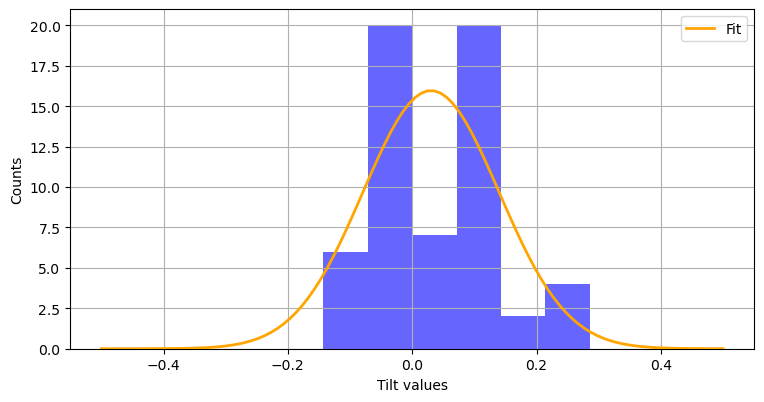

In [152]:
plt.figure(figsize=(30, 15))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
ax1 = plt.subplot(gs[0, 0])

# Tilt data
tilt_vals = tilt_list_without_correction
bins_tilt_hist = np.linspace(-.5, .5, 15)
n_tilt, bins_tilt, _ = ax1.hist(tilt_vals, bins=bins_tilt_hist, color='blue', alpha=0.6, lw=2, zorder=1)
x_vals_tilt = 0.5 * (bins_tilt[:-1] + bins_tilt[1:])
mu, std = norm.fit(tilt_vals)
mu_theo, std_theo = 0, 1
# y = norm.pdf(x_vals_tilt, mu, std)

fit, error = fit_gaussian(x_vals_tilt, n_tilt)
print(fit)
print(error)
y = gauss_function(np.linspace(-.5, .5, 100), *fit)

ax1.plot(np.linspace(-.5, .5, 100), y, lw=2, color='orange', ls='solid', zorder=4, label=r"Fit")
ax1.set_xlabel('Tilt values')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.grid()

muf.save_figures(PlotDir, name='rma_tilt_histogram')

plt.show()

[23.3562952   0.91570253  0.13456444]
[1.70281354 0.0114304  0.01122877]


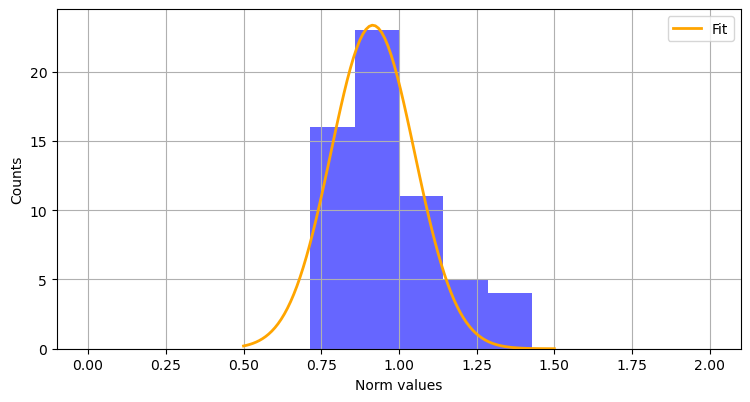

In [151]:
plt.figure(figsize=(30, 15))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
ax2 = plt.subplot(gs[0, 0])

# Norm data
norm_vals = norm_list_without_correction
bins_norm_hist = np.linspace(0, 2, 15)
n_norm, bins_norm, _ = ax2.hist(norm_vals, bins=bins_norm_hist, color='blue', alpha=0.6, lw=2, zorder=1)
x_vals_norm = 0.5 * (bins_norm[:-1] + bins_norm[1:])
mu_norm, std_norm = norm.fit(norm_vals)
# y_norm = norm.pdf(x_vals_norm, mu_norm, std_norm)

fit, error = fit_gaussian(x_vals_norm, n_norm)
print(fit)
print(error)
y = gauss_function(np.linspace(.5, 1.5, 100), *fit)

ax2.plot(np.linspace(.5, 1.5, 100), y, lw=2, color='orange', ls='solid', zorder=4,label=r"Fit")
ax2.set_xlabel('Norm values')
ax2.set_ylabel('Counts')
ax2.legend()
ax2.grid()
# ax2.set_xlim(.5, 2)

muf.save_figures(PlotDir, name='rma_norm_histogram')

plt.show()

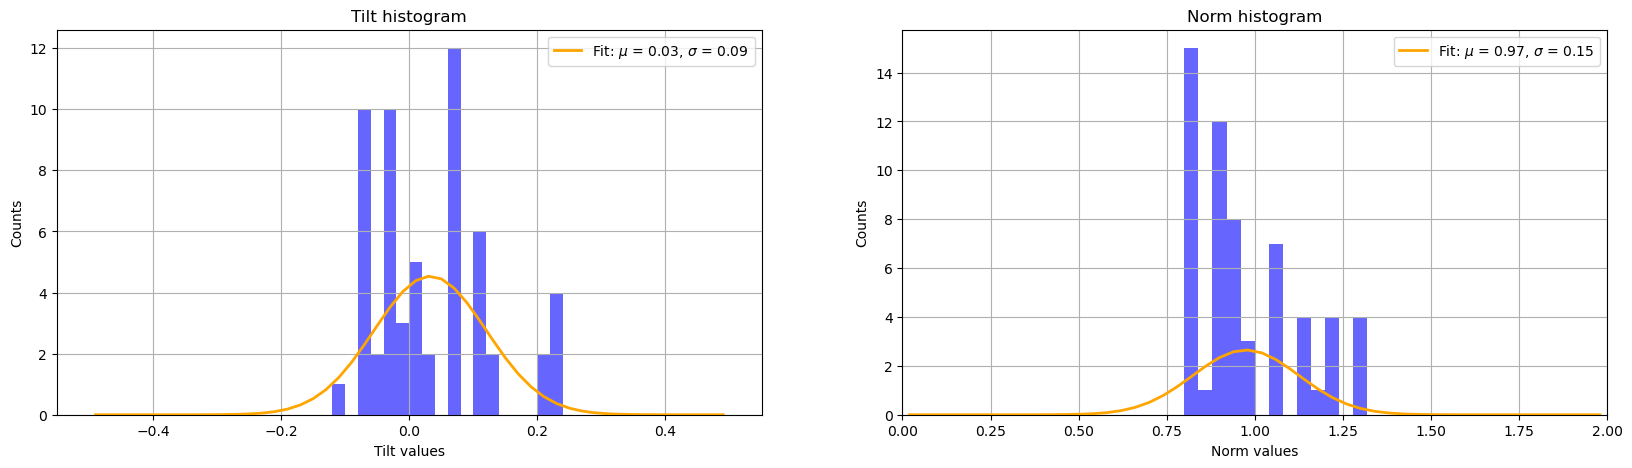

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Tilt data
tilt_vals = tilt_list_without_correction
bins_tilt_hist = np.linspace(-.5, .5, 51)
n_tilt, bins_tilt, _ = ax1.hist(tilt_vals, bins=bins_tilt_hist, color='blue', alpha=0.6, lw=2, zorder=1)
x_vals_tilt = 0.5 * (bins_tilt[:-1] + bins_tilt[1:])
mu, std = norm.fit(tilt_vals)
y = norm.pdf(x_vals_tilt,mu, std)
ax1.plot(x_vals_tilt, y, lw=2, color='orange', ls='solid', zorder=4,label=r"Fit: $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, std))
ax1.set_xlabel('Tilt values')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.grid()
ax1.set_title(f"Tilt histogram")

# Norm data
norm_vals = norm_list_without_correction
bins_norm_hist = np.linspace(0, 2, 51)
n_norm, bins_norm, _ = ax2.hist(norm_vals, bins=bins_norm_hist, color='blue', alpha=0.6, lw=2, zorder=1)
x_vals_norm = 0.5 * (bins_norm[:-1] + bins_norm[1:])
mu_norm, std_norm = norm.fit(norm_vals)
y_norm = norm.pdf(x_vals_norm, mu_norm, std_norm)

ax2.plot(x_vals_norm, y_norm, lw=2, color='orange', ls='solid', zorder=4,label=r"Fit: $\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu_norm, std_norm))
ax2.set_xlabel('Norm values')
ax2.set_ylabel('Counts')
ax2.legend()
ax2.grid()
ax2.set_xlim(0, 2)
ax2.set_title(f"Norm histogram")

# muf.save_figures(PlotDir, name='rma_norm_and_tilt_histogramm')

plt.show()

### Bias

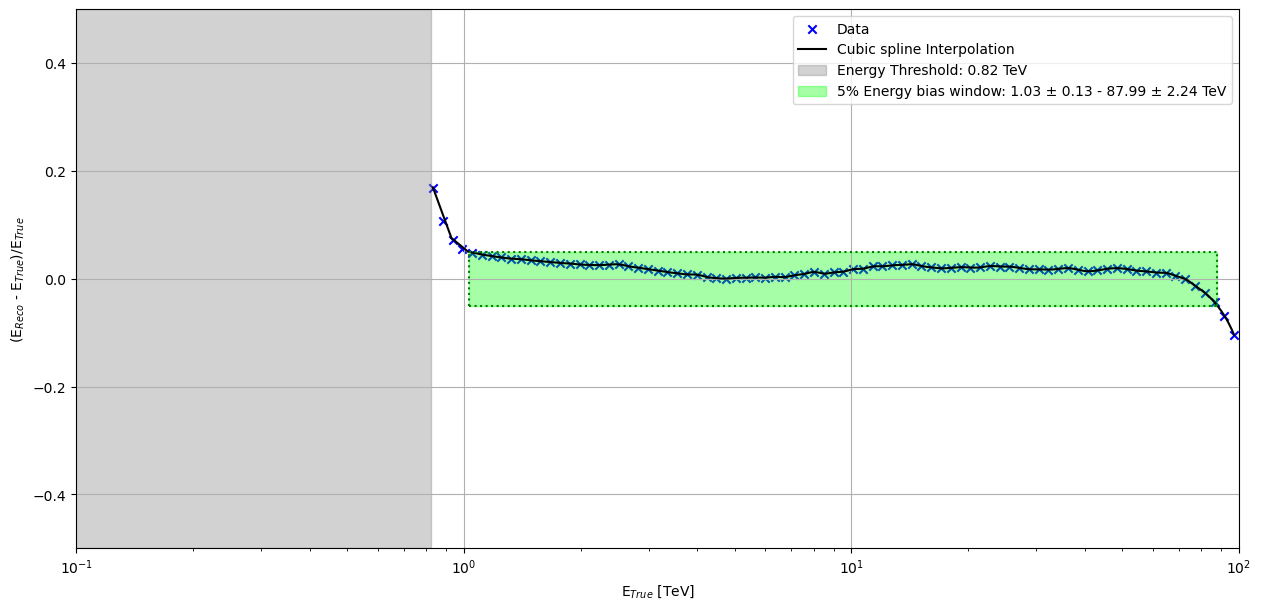

In [32]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.misc import derivative  # Import derivative for error propagation

# Obtain energy and bias data
energy = np.array(stacked_without_correction.edisp.get_edisp_kernel().axes["energy_true"].center)
energy_min = stacked_without_correction.energy_range_total[0].value
bias = np.array(stacked_without_correction.edisp.get_edisp_kernel().get_bias(energy))

mask = (energy >= energy_min)

# Filtered data
x = energy[mask]
y = bias[mask]

# Create a cubic spline interpolation function with extrapolation
f_cubic = interp1d(x, y, kind='cubic', fill_value='extrapolate')

# Find energies and errors for bias 0.05 and bias 0
bias_energy_below_5_percent_low, error_low = find_energy_with_sensitivity(f_cubic, bias_percent*1e-2, initial_guess=0)
bias_energy_below_5_percent_high, error_high = find_energy_with_sensitivity(f_cubic, -bias_percent*1e-2, initial_guess=70.0)

# Plotting
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))

# Scatter plot of bias data
ax1.scatter(x, y, marker ='x', label='Data', color='blue')

# Interpolation plot
x_new = np.linspace(min(x), max(x), 1000)
y_new = f_cubic(x_new)
ax1.plot(x_new, y_new, label='Cubic spline Interpolation', color='black')

# Energy threshold area
ax1.axvspan(xmin=0, xmax=stacked_without_correction.energy_range_total[0].value, color='grey', alpha=.35, label=f'Energy Threshold: {round(stacked_without_correction.energy_range_total[0].value, 2)} TeV')

# Vertical lines for bias energy thresholds
ax1.vlines(bias_energy_below_5_percent_low, -bias_percent*1e-2, bias_percent*1e-2, ls=':', color='green')
ax1.vlines(bias_energy_below_5_percent_high, -bias_percent*1e-2, bias_percent*1e-2, ls=':', color='green')

# Horizontal lines for bias threshold
ax1.hlines(bias_percent*1e-2, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high, ls=':', color='green')
ax1.hlines(-bias_percent*1e-2, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high, ls=':', color='green')

# Label for the bias window
label_box = (f'{bias_percent}% Energy bias window: {round(bias_energy_below_5_percent_low, 2)} ± {round(error_low, 2)} - 'f'{round(bias_energy_below_5_percent_high, 2)} ± {round(error_high, 2)} TeV')
ax1.axvspan(xmin=bias_energy_below_5_percent_low, xmax=bias_energy_below_5_percent_high, ymin=0.45, ymax=.55, color='lime', alpha=.35, label=label_box)

# Set limits and labels
ax1.set_xlim(1e-1, 1e2)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('E$_{True}$ [TeV]')
ax1.set_ylabel(r'(E$_{Reco}$ - E$_{True}$)/E$_{True}$')
ax1.legend()
ax1.grid()
ax1.set_xscale('log')

# Save the figure if needed
# muf.save_figures(PlotDir, name='rma_bias_stacked_dataset')

plt.show()

### $\sqrt{TS}$ Maps

In [153]:
catalog_4FGL = SourceCatalog4FGL('/home/wecapstor1/caph/caph101h/software/miniforge3/bin/gammapy-datasets/1.2/catalogs/fermi/gll_psc_v32.fit.gz')
source_fermi_J1044 = catalog_4FGL["4FGL J1036.2-5936"]
mask_roi = source_fermi_J1044.position.separation(catalog_4FGL.positions) < 2.5 * u.deg

catalog_4FGL_roi = catalog_4FGL[mask_roi]
print("Number of sources :", len(catalog_4FGL_roi.table))

Number of sources : 15


In [155]:
dataset_000 = stacked_without_correction.copy()

energy_mask = dataset_000.counts.geom.energy_mask(energy_min=1.16* u.TeV, energy_max=90 * u.TeV)

dataset_000.mask_fit = energy_mask

print(f'Analysing energy range from {dataset_000.energy_range_total[0].value} TeV to {dataset_000.energy_range_total[1].value} TeV')

estimator = ExcessMapEstimator(correlation_radius=.6 * u.deg, energy_edges=[1.16, 90]*u.TeV)
lima_maps = estimator.run(dataset_000)
significance_map = lima_maps.sqrt_ts
# significance_map = significance_map.cutout(target, width=(7,5)*u.deg)

Analysing energy range from 1.1689518164985782 TeV to 88.95134973108235 TeV


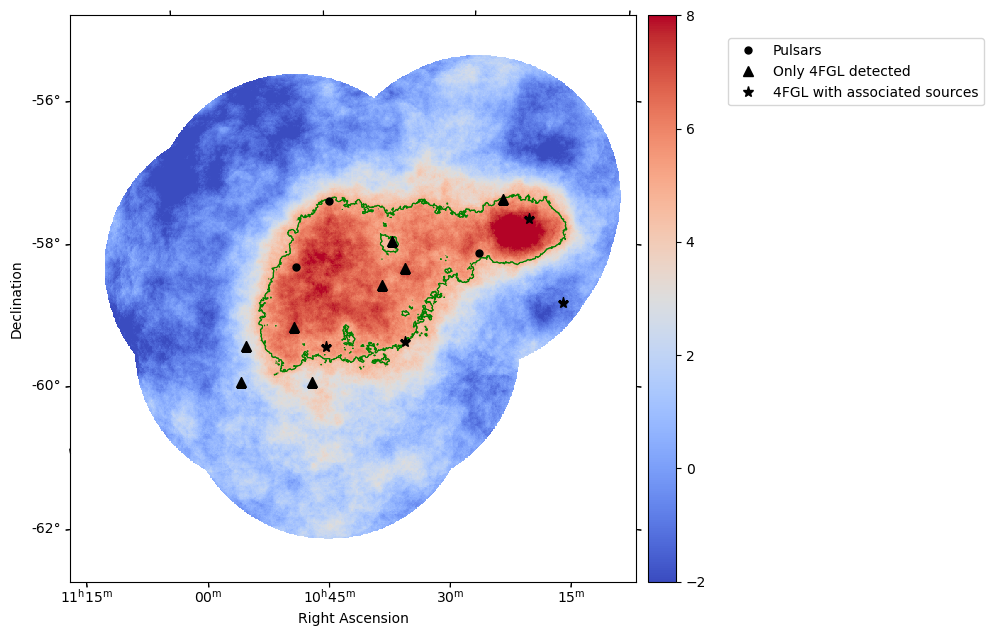

In [157]:
sigma_level = [5]
color = ['green']
significance_array = np.squeeze(significance_map)
contour_legend = Line2D([0], [0], color=color[0], label=rf'{sigma_level[0]}$\sigma$')

plt.figure(figsize=(30, 25))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  
################################################################################################################################
ax1 = plt.subplot(gs[0, 0], projection=significance_map.geom.wcs)

significance_map.plot(ax=ax1, add_cbar=True, cmap='coolwarm', vmin=-2, vmax=8)

ax1.contour(significance_array, levels=[5], colors=color, linewidths = .75)

marker_psr = dict(marker='o', color='black', markersize=5)
plot_position(ax1, 157.12, -58.32, '', marker_psr) # PSR J1028-5819
plot_position(ax1, 161.14, -57.62, '', marker_psr) # PSR J1044-5737 
plot_position(ax1, 162.05, -58.54, '', marker_psr) # PSR B1046-58 


psr_sources = ["4FGL J1028.5-5819", "4FGL J1044.4-5737", "4FGL J1048.2-5832"]

associated_source = ["4FGL J1018.9-5856", "4FGL J1023.3-5747e", "4FGL J1036.2-5936", "4FGL J1045.1-5940"]

marker_4fgl_unassociated_sources = dict(marker='^', color='black', markersize=7)
marker_4fgl_associated_sources = dict(marker='*', color='black', markersize=8)

for models in catalog_4FGL_roi.to_models():
    if (models.name not in psr_sources) & (models.name not in associated_source):
        plot_position(ax1, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_4fgl_unassociated_sources)
    elif models.name in associated_source:
        plot_position(ax1, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_4fgl_associated_sources)       

ax1.contour(significance_array, levels=[5], colors=color, linewidths = .75, zorder=0)


legend_handles = [
    Line2D([0], [0], marker='o', color='black', markersize=5, linestyle='None', label='Pulsars'),
    Line2D([0], [0], marker='^', color='black', markersize=7, linestyle='None', label='Only 4FGL detected'),
    Line2D([0], [0], marker='*', color='black', markersize=8, linestyle='None', label='4FGL with associated sources')
]

ax1.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.15, 0.9))

muf.save_figures(PlotDir, name="sqrt_ts_map_rma_with_fermi_sources")

plt.show()